In [1]:
#Import packages
import nltk, re, string, random, tqdm
import pandas as pd
import tqdm 
import matplotlib.pyplot as plt 
from matplotlib import ticker

from nltk import classify, NaiveBayesClassifier, FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Raw training data

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [4]:
#lematization funtion, normalises words to canonical form
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [5]:
#Function to remove noise (the, it, @ for twitter handles and others)
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [6]:
#Make clean sample out of cleaned data
stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [7]:
#Word density function
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)

freq_dist_pos = FreqDist(all_pos_words)
#print(freq_dist_pos.most_common(10))

In [8]:
#Frequency distribution
freq_dist_pos = FreqDist(all_pos_words)
#print(freq_dist_pos.most_common(10))

In [9]:
#Function to fetch cleaned tokens for modelling
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [10]:
print(len(positive_cleaned_tokens_list))
print(len(negative_cleaned_tokens_list))

5000
5000


In [11]:
#Split dataset
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [12]:
#classifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9946666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2066.9 : 1.0
                      :) = True           Positi : Negati =   1650.3 : 1.0
                     sad = True           Negati : Positi =     24.2 : 1.0
                     bam = True           Positi : Negati =     22.3 : 1.0
                follower = True           Positi : Negati =     20.9 : 1.0
                 welcome = True           Positi : Negati =     19.7 : 1.0
                    sick = True           Negati : Positi =     17.0 : 1.0
                     x15 = True           Negati : Positi =     15.7 : 1.0
                    blog = True           Positi : Negati =     12.3 : 1.0
                  arrive = True           Positi : Negati =     11.8 : 1.0
None


In [15]:
#Custom tweet tester, model seems to not understand sarcasm
custom_tweet = 'doge is the shitty coin'

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive


## Running sentiment analysis on our data

Defining function to do sentiment analysis

In [111]:
def sentiment_analysis(DataFrame, column_name):
    """
    Takes in a DataFrame, and a string specifying the name of the column where the tweets are located
    Returns the DataFrame with a sentiment analysis column appended 
    """
    
    #Creating temp_list of all text bits in DataFrame
    temp_list = DataFrame[column_name].tolist()
    
    # For loop that finds sentiment of each element in temp list as -1 (negative) or 1 (positive)

    output_list = []

    for i in tqdm.tqdm(temp_list):
        custom_text = str(i)
        custom_tokens = remove_noise(word_tokenize(custom_text))
        if classifier.classify(dict([token, True] for token in custom_tokens)) == 'Negative':
            output_list.append(-1)
        else:
            output_list.append(1)
    DataFrame['sentiment'] = pd.DataFrame(output_list)
    
    return DataFrame

### Load in dataset

In [117]:
twitter_API_df = pd.read_csv('twitter_API_data_cleaned.csv', encoding='utf-8')

### OBS: Takes around 10 mins to run

In [118]:
### OLD CODE ###

#Creating temp_list of all text bits in DataFrame

#temp_list = twitter_API_df['text'].tolist()

# For loop that finds sentiment of each element in temp list as -1 (negative) or 1 (positive)

#output_list = []

#for i in tqdm.tqdm(temp_list):
#    custom_text = str(i)
#    custom_tokens = remove_noise(word_tokenize(custom_text))
#    if classifier.classify(dict([token, True] for token in custom_tokens)) == 'Negative':
#        output_list.append(-1)
#    else:
#        output_list.append(1)
#output_df = pd.DataFrame(output_list)
#
#output_df.head(5)

In [119]:
twitter_API_df = sentiment_analysis(twitter_API_df, 'text')

100%|█████████████████████████████████████████████████████████████████████████| 145933/145933 [11:58<00:00, 203.21it/s]


In [122]:
twitter_API_df.head(2)

,text,author_id,date,date_hour,retweet_count,reply_count,like_count,quote_count,sentiment
0,@alqsyy @Mutantduckclub8 RYOGE- The shiba kill...,1557092549638111233,2022-08-15,2022-08-15 14:00:00,0,0,0,0,-1
1,@Amrit45970471 @palletjacker69 Join doge mutan...,1551828952011997184,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1


In [123]:
### OLD CODE ###

# Adding the sentiment as a column to the OG DataFrame
#twitter_API_df['sentiment'] = output_df

#twitter_API_df.head(2)

### Saving as CSV file for later use

In [124]:
twitter_API_df.to_csv('twitter_API_data_sentiment_NLKT.csv')

In [83]:
### Number of tweets mentioning 'doge' in each sentiment category
tweets_by_sentiment = twitter_API_df['text'].groupby(twitter_API_df['sentiment']).count()

### Sum and mean of numerical sentiment value per day (ie. "Sentiment per day/hour")
sum_sentiment_per_day = twitter_API_df['sentiment'].groupby(twitter_API_df['date']).sum()
mean_sentiment_per_day = twitter_API_df['sentiment'].groupby(twitter_API_df['date']).mean()

sum_sentiment_per_hour = twitter_API_df['sentiment'].groupby(twitter_API_df['date_hour']).sum()
mean_sentiment_per_hour = twitter_API_df['sentiment'].groupby(twitter_API_df['date_hour']).mean()

#Dataframe with sum and mean per hour
sentiment_per_hour = pd.DataFrame({'Sum': sum_sentiment_per_hour, 'Mean': mean_sentiment_per_hour}).reset_index()

### Saving sentiment_per_hour as CSV for later use

In [125]:
sentiment_per_hour.to_csv('twitter_API_data_sentiment_NLKT_per_hour.csv')

### General distribution fo sentiment

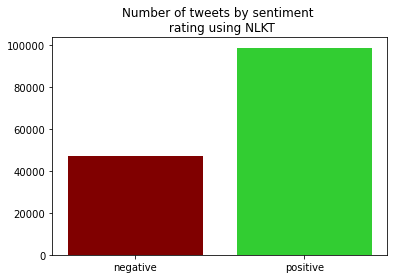

In [91]:
plt.bar(['negative', 'positive'], tweets_by_sentiment, color =['maroon','limegreen'])
plt.title('Number of tweets by sentiment \n rating using NLKT')

plt.show()

### Basic plotting for visual analysis

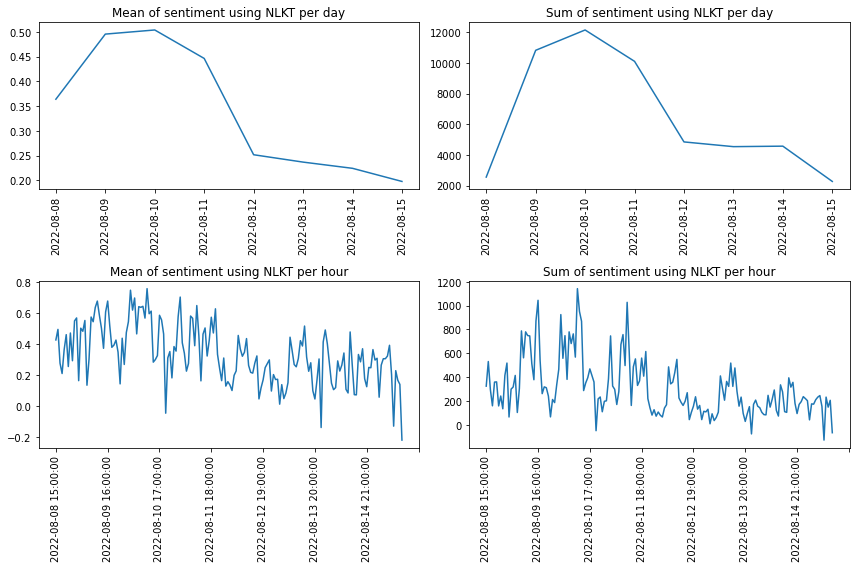

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))

ax1[0].plot(mean_sentiment_per_day)
ax1[0].set_title('Mean of sentiment using NLKT per day')
ax1[0].tick_params(axis='x',rotation=90)

ax1[1].plot(sum_sentiment_per_day)
ax1[1].set_title('Sum of sentiment using NLKT per day')
ax1[1].tick_params(axis='x',rotation=90)


ax2[0].plot(mean_sentiment_per_hour)
ax2[0].set_title('Mean of sentiment using NLKT per hour')
ax2[0].xaxis.set_major_locator(ticker.MaxNLocator(8))
ax2[0].tick_params(axis='x',rotation=90)

ax2[1].plot(sum_sentiment_per_hour)
ax2[1].set_title('Sum of sentiment using NLKT per hour')
ax2[1].xaxis.set_major_locator(ticker.MaxNLocator(8))
ax2[1].tick_params(axis='x',rotation=90)


fig.tight_layout()
plt.show()